In [36]:
import numpy as np
import pandas as pd
import os
from typing import List, Optional, Dict
import gc
import missingno as msno
import matplotlib.pyplot as plt
import math
from scipy import stats

# Set precision to 2 decimal places
pd.options.display.float_format = '{:.2f}'.format

# Suppress all warnings
import warnings
warnings.filterwarnings("ignore")

### Data Read

In [37]:
def read_parquet(input_dir: str, years: Optional[List[int]] = None) -> Dict[int, pd.DataFrame]:
    """
    Reads Parquet files for specified years from the input directory.

    Args:
        input_dir (str): The directory where Parquet files are stored.
        years (Optional[List[int]]): A list of years to read. If None, read all available years.

    Returns:
        Dict[int, pd.DataFrame]: A dictionary with years as keys and pandas DataFrames as values.
    """
    data_frames = {}
    available_years = [int(d.split('=')[1]) for d in os.listdir(input_dir) if d.startswith('year=')]
    years_to_read = years if years is not None else available_years

    for year in years_to_read:
        year_path = os.path.join(input_dir, f'year={year}')
        if os.path.exists(year_path):
            df = pd.read_parquet(year_path)
            df['year'] = year  # Add the year column 
            data_frames[year] = df
        else:
            print(f"Warning: No data found for year {year}")

    return data_frames

In [38]:
years = [2015, 2016, 2017, 2018, 2019] 
output_directory = "../data/DS/NSDUH"

# Read saved data 
df = pd.concat(read_parquet(output_directory, years).values())   
        

## Sharan Raj Sivakumar Hypothesis

### Hypothesis 1: Early drug use, particularly during adolescence, is a risk factor for the development of mental health issues. 
#### Null Hypothesis: There is no relationship between early drug use and the development of mental health issues.
#### Alternative Hypothesis: Early drug use is associated with an increased risk of developing mental health issues.

In [39]:
identity_columns_H1 = ['QUESTID2']
# drug_usage_columns_H1 = ['MJEVER','MJAGE', 'BLNTEVER', 'BLNTAGE','COCEVER', 'COCAGE', 'CRKEVER', 'CRKAGE', 'HEREVER', 'HERAGE', 'HALLUCEVR','HALLUCAGE', 'METHAMEVR', 'METHAMAGE']

drug_usage_columns_H1 = ['MJAGE', 'BLNTAGE','COCAGE',  'CRKAGE',  'HERAGE', 'HALLUCAGE', 'METHAMAGE']


mental_health_columns_H1 = ['YMDELT']

columns_of_interest_H1 = identity_columns_H1 + drug_usage_columns_H1 + mental_health_columns_H1


In [40]:
# Creating a copy of df for Hypothesis 2 analysis
df_H1 = df[columns_of_interest_H1].copy()

In [41]:
# Get unique values for each column
for column in df_H1.columns:
    unique_values = df_H1[column].unique()
    print(f"\nUnique values for {column}:")
    print(unique_values)


Unique values for QUESTID2:
[25095143 13005143 67415143 ... 38044730 43164730 92074730]

Unique values for MJAGE:
[991  15  14  18 985  12  21  24  17  13  22  35  16  20  19  23  25  36
  38 994   7  30  32   9  11  29  10  27  28  26  31  39   8  37  55  40
  45  34  51  50 998  44  76 997  48  42   5  56  52   6   2  47  43   3
  33   4  54  49  58  72  65  46  57  64  69  62  60  75   1  77  41  78
  74  68  53  61  66  71  67  59  80  63  70  81  79  73  82]

Unique values for BLNTAGE:
[991  26  16  21  14  15 994  18  17  35  19  20  12  13  22  40  36  30
  25  10  23  34  45   6  28  11  56   8  29  24  38  42 997  27  54  32
  31  60  47 981 998   9  55  50   7  37   2  49  48  59  43  53   1  46
 985  33   3  44  41  58  39  52  57  65  51   5  62  66   4  61  63  76
  68  73  64  70  69]

Unique values for COCAGE:
[991  16  13  20  15  24  18  34  19  25  22  17  14  21  27  23  26  12
  50  35  30  37  29  36  28  31 994  38  48 997  39  40  33  32  11 985
   2  55  45 998

In [42]:
# Clean the data
df_H1 = df_H1.drop_duplicates()  # Remove duplicates

In [43]:
df_H1[drug_usage_columns_H1+mental_health_columns_H1].describe()

,MJAGE,BLNTAGE,COCAGE,CRKAGE,HERAGE,HALLUCAGE,METHAMAGE,YMDELT
count,281835.00,281835.00,281835.00,281835.00,281835.00,281835.00,281835.00,66390.00
mean,575.25,763.95,877.24,965.19,974.43,851.72,947.53,1.80
std,481.69,411.66,312.15,155.91,125.60,340.62,200.71,0.40
min,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
25%,17.00,991.00,991.00,991.00,991.00,991.00,991.00,2.00
50%,991.00,991.00,991.00,991.00,991.00,991.00,991.00,2.00
75%,991.00,991.00,991.00,991.00,991.00,991.00,991.00,2.00
max,998.00,998.00,998.00,998.00,998.00,998.00,998.00,2.00


In [44]:
# Define a dictionary for replacements based on the code conventions
code_replacements = {
    93: np.nan,
    993: np.nan,
    9993: np.nan,
    94: np.nan,  # Don't Know
    994: np.nan,
    9994: np.nan,
    97: np.nan,  # Refused
    997: np.nan,
    9997: np.nan,
    98: np.nan,  # Blank
    998: np.nan,
    9998: np.nan,
    99: np.nan,  # Legitimate Skip
    999: np.nan,
    9999: np.nan,
    89: np.nan,  
    989: np.nan,
    9989: np.nan,
    85: np.nan, # Bad data
    985: np.nan,
    9985: np.nan
}

# Apply the replacements to the DataFrame
df_H1.replace(code_replacements, inplace=True)

# Drop rows with missing values
df_H1.dropna(inplace=True)

In [45]:
# Convert all to integer
df_H1 = df_H1.astype(int)

In [46]:
# Get unique values for each column
for column in df_H1.columns:
    unique_values = df_H1[column].unique()
    print(f"\nUnique values for {column}:")
    print(unique_values)


Unique values for QUESTID2:
[25095143 70925143 63765143 ... 38044730 43164730 92074730]

Unique values for MJAGE:
[991  14  12  15  17  16  13  11   9  10   8   5   7   2   6   1   3   4]

Unique values for BLNTAGE:
[991  16  14  15  17  12  13  10   8   6 981   7  11   9   1   2   5   3
   4]

Unique values for COCAGE:
[991  15  14  16  17  12  13  10   8   7   9  11   1   6]

Unique values for CRKAGE:
[991  14  15  13  12   8  17  16  11   6]

Unique values for HERAGE:
[991  15  14  13  12   9  16  17  11   5  10]

Unique values for HALLUCAGE:
[991  14  15  17  12  13  16   2   1  10  11   9   8   6   7   4   5]

Unique values for METHAMAGE:
[991  14  15  12  16  17  10  11   9  13   1   8   5   2   6]

Unique values for YMDELT:
[1 2]


In [47]:
# Condition for never used drugs
never_used_condition = (df_H1 == 991) | (df_H1 == 981)

# DataFrame for no drug use
no_drug_use_df = df_H1[never_used_condition[drug_usage_columns_H1].all(axis=1)]
no_drug_use_df["Drug_Use"] = 0

# DataFrame for any drug use
any_drug_use_df = df_H1[~never_used_condition[drug_usage_columns_H1].all(axis=1)]
any_drug_use_df["Drug_Use"] = 1

df_H1 = pd.concat([no_drug_use_df,any_drug_use_df])

# Add a binary column for drug use
# df_H1['Drug_Use'] = ~(df_H1 == 991).all(axis=1) & ~(df_H1 == 981).all(axis=1)


print(f"No Drug Use DataFrame Shape:{df_H1[df_H1['Drug_Use']==0].shape}")

print(f"Any Drug Use DataFrame Shape:{df_H1[df_H1['Drug_Use']==1].shape}")

No Drug Use DataFrame Shape:(53755, 10)
Any Drug Use DataFrame Shape:(11040, 10)


In [48]:
# Hypothesis Test
t_stat, p_value = stats.ttest_ind(no_drug_use_df['YMDELT'].dropna(), any_drug_use_df['YMDELT'].dropna())

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

T-statistic: 43.34074470538926
P-value: 0.0


### Interpretation of Results:

- **T-statistic**: 43.341  
  A **T-statistic** of 43.341 is very large. This indicates that the difference between early drug users and non-drug users (in terms of developing mental health issues) is much greater than what would be expected under the null hypothesis. In other words, this large T-value suggests a strong association between early drug use and the development of mental health issues.

- **P-value**: 0.0  
  A **P-value** of 0.0 (or something extremely close to 0) indicates that the likelihood of observing this data if the null hypothesis were true (i.e., if there really is no association between early drug use and mental health issues) is virtually **zero**.

---

### Conclusion:
- Given the very high T-statistic and the P-value of 0.0, you would **reject the null hypothesis** with great confidence.
- There is very strong evidence to suggest that early drug use, particularly during adolescence, is a significant risk factor for the development of mental health issues.
- The result implies that the observed relationship is not due to random chance but is likely a true effect in the population.

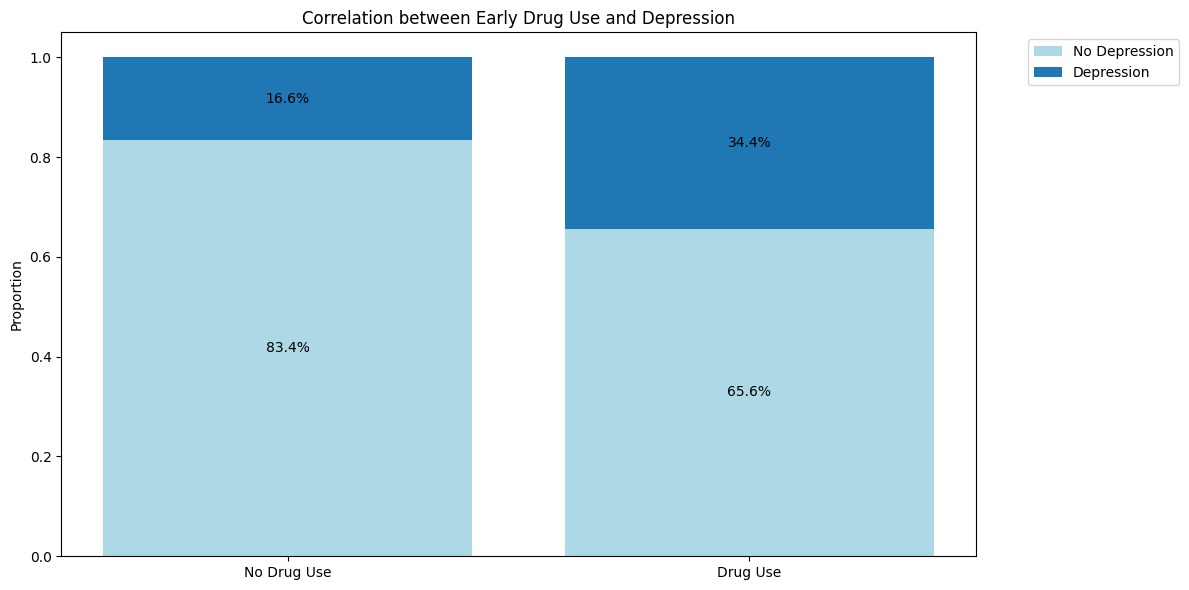

In [49]:
# Calculate the proportions
drug_use_0 = df_H1[df_H1['Drug_Use'] == 0]['YMDELT'].value_counts(normalize=True)
drug_use_1 = df_H1[df_H1['Drug_Use'] == 1]['YMDELT'].value_counts(normalize=True)

# Create the stacked bar chart
fig, ax = plt.subplots(figsize=(12, 6))

labels = ['No Drug Use', 'Drug Use']
no_depression = [drug_use_0.get(2, 0), drug_use_1.get(2, 0)]
depression = [drug_use_0.get(1, 0), drug_use_1.get(1, 0)]

ax.bar(labels, no_depression, label='No Depression', color='lightblue')
ax.bar(labels, depression, bottom=no_depression, label='Depression')

ax.set_ylabel('Proportion')
ax.set_title('Correlation between Early Drug Use and Depression')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Add percentage labels on the bars
for i, (no_dep, dep) in enumerate(zip(no_depression, depression)):
    ax.text(i, no_dep/2, f'{no_dep:.1%}', ha='center', va='center')
    ax.text(i, no_dep + dep/2, f'{dep:.1%}', ha='center', va='center')

plt.tight_layout()
plt.show()

### Key Observations:

1. **No Drug Use Group**:
   - **83.4%** of individuals who did not use drugs early are not depressed.
   - **16.6%** of individuals in the "No Drug Use" group suffer from depression.

2. **Drug Use Group**:
   - **65.6%** of individuals who used drugs early are not depressed.
   - **34.4%** of individuals in the "Drug Use" group suffer from depression.

---

### Interpretation:
- **Higher Depression in Drug Users**: The proportion of individuals with depression is notably higher in the "Drug Use" group (**34.4%**) compared to the "No Drug Use" group (**16.6%**).
- **Lower Depression in Non-Drug Users**: Conversely, individuals who did not engage in early drug use show a much higher rate of being non-depressed (**83.4%**) compared to the "Drug Use" group (**65.6%**).

---

### Conclusion:
The chart visually supports the hypothesis that early drug use is associated with a higher likelihood of developing depression. There is a clear difference between the two groups, with a higher proportion of depression among those who used drugs early in life. This suggests that early drug use could be a risk factor for depression, as the relationship is clearly visible in the data.

### Hypothesis 2: Individuals who are married or widowed are less likely to experience suicidal thoughts compared to individuals who are single. 
#### Null Hypothesis: There is no relationship between being marital status and experiencing suicidal thoughts.
#### Alternative Hypothesis: Married or widowed individuals have lesser chance of experiencing suicidal thoughts 

In [50]:
identity_columns_H2 = ['QUESTID2']

independent_columns_H2 = ['IRMARIT']

dependent_columns_H2 = ['SUICTHNK']

columns_of_interest_H2 = identity_columns_H2 + independent_columns_H2 + dependent_columns_H2


In [51]:
# Creating a copy of df for Hypothesis 3 analysis
df_H2 = df[columns_of_interest_H2].copy()

In [52]:
# Get unique values for each column
for column in df_H2.columns:
    if column not in identity_columns_H2:
        unique_values = df_H2[column].unique()
        print(f"\nUnique values for {column}:")
        print(unique_values)


Unique values for IRMARIT:
[nan  1.  4.  2. 99.  3.]

Unique values for SUICTHNK:
[99  2 94 97  1 85 98 89]


In [53]:
# Clean the data
df_H2 = df_H2.drop_duplicates()  # Remove duplicates

In [54]:
df_H2[independent_columns_H2+dependent_columns_H2].describe()

,IRMARIT,SUICTHNK
count,224857.00,282003.00
mean,14.22,25.92
std,31.14,41.85
min,1.00,1.00
25%,1.00,2.00
50%,4.00,2.00
75%,4.00,2.00
max,99.00,99.00


In [55]:
# Define a dictionary for replacements based on the code conventions for IRMARIT
code_replacements = {1:"Married", 2:"Widowed", 3:np.nan, 4:"Single", 99: np.nan}


# Apply the replacements to the DataFrame
df_H2["IRMARIT"].replace(code_replacements, inplace=True)


# Define a dictionary for replacements based on the code conventions for SUICTHNK
code_replacements = {85:np.nan, 89:np.nan, 94:np.nan, 97:np.nan, 98:np.nan, 99: np.nan}

# Apply the replacements to the DataFrame
df_H2["SUICTHNK"].replace(code_replacements, inplace=True)

# Drop rows with missing values
df_H2.dropna(inplace=True)

In [56]:
# Convert all to integer
df_H2["SUICTHNK"] = df_H2["SUICTHNK"].astype(int)

In [57]:
# Get unique values for each column
for column in df_H2.columns:
    if column not in identity_columns_H2:
        unique_values = df_H2[column].unique()
        print(f"\nUnique values for {column}:")
        print(unique_values)


Unique values for IRMARIT:
['Married' 'Single' 'Widowed']

Unique values for SUICTHNK:
[2 1]


In [58]:
single_df_H2 = df_H2[df_H2["IRMARIT"]=="Single"]
not_single_df_H2 = df_H2[df_H2["IRMARIT"]!="Single"]


In [59]:
# Hypothesis Test
t_stat, p_value = stats.ttest_ind(not_single_df_H2['SUICTHNK'], single_df_H2["SUICTHNK"])

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

T-statistic: 50.2948528555206
P-value: 0.0


### Results:
- **T-statistic**: 50.295  
  A **T-statistic** of 50.295 is extremely high, indicating a significant difference between the two groups regarding suicidal thoughts. This suggests that the observed data deviate greatly from what would be expected under the null hypothesis.

- **P-value**: 0.0  
  A **P-value** of 0.0 (or very close to it) indicates that the probability of observing such extreme results, assuming the null hypothesis is true, is virtually zero. This strongly suggests that the null hypothesis can be rejected.

---

### Conclusion:
Given the very high T-statistic and the P-value of 0.0, we can confidently **reject the null hypothesis**. There is compelling evidence to support the alternative hypothesis that individuals who are single are significantly more likely to experience suicidal thoughts compared to those who are married or widowed. This result highlights the potential individuals enjoy a sense of companionship(present or former) contributes positively to their happiness.

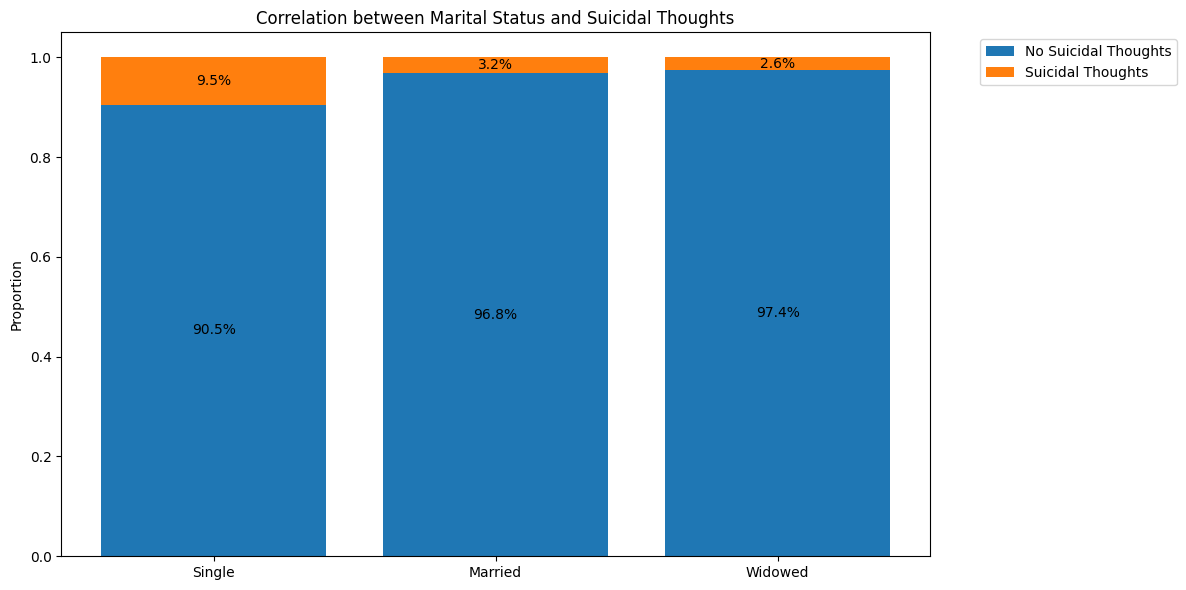

In [60]:
# Calculate the proportions for each marital status
marital_status_0 = df_H2[df_H2['IRMARIT'] == 'Single']['SUICTHNK'].value_counts(normalize=True)
marital_status_1 = df_H2[df_H2['IRMARIT'] == 'Married']['SUICTHNK'].value_counts(normalize=True)
marital_status_2 = df_H2[df_H2['IRMARIT'] == 'Widowed']['SUICTHNK'].value_counts(normalize=True)


# Create the stacked bar chart
fig, ax = plt.subplots(figsize=(12, 6))

labels = ['Single', 'Married', 'Widowed']
no_suicidal_thoughts = [
    marital_status_0.get(2, 0),  # No for Single
    marital_status_1.get(2, 0),  # No for Marriage
    marital_status_2.get(2, 0),  # No for Widowed
]
suicidal_thoughts = [
    marital_status_0.get(1, 0),  # Yes for Single
    marital_status_1.get(1, 0),  # Yes for Marriage
    marital_status_2.get(1, 0),  # Yes for Widowed
]

ax.bar(labels, no_suicidal_thoughts, label='No Suicidal Thoughts')
ax.bar(labels, suicidal_thoughts, bottom=no_suicidal_thoughts, label='Suicidal Thoughts')

ax.set_ylabel('Proportion')
ax.set_title('Correlation between Marital Status and Suicidal Thoughts')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Add percentage labels on the bars
for i, (no_suicidal, suicidal) in enumerate(zip(no_suicidal_thoughts, suicidal_thoughts)):
    ax.text(i, no_suicidal / 2, f'{no_suicidal:.1%}', ha='center', va='center')
    ax.text(i, no_suicidal + suicidal / 2, f'{suicidal:.1%}', ha='center', va='center')

plt.tight_layout()
plt.show()


### Key Observations:

1. **Single Individuals**:
   - **90.5%** of single individuals donot experience having suicidal thoughts.
   - **9.5%** of single individuals experience suicidal thoughts.

2. **Married Individuals**:
   - **96.8%** of married individuals donot experience having suicidal thoughts.
   - **3.2%** of married individuals experience suicidal thoughts.

3. **Widowed Individuals**:
   - **97.4%** of widowed individuals donot experience having suicidal thoughts.
   - **2.6%** of widowed individuals experience suicidal thoughts.

---

### Interpretation:
- **Higher Suicidal Thoughts in Single Individuals**: The proportion of individuals reporting suicidal thoughts is significantly higher in singles compared to married and widowed individual.
---

### Conclusion:
The chart visually supports the hypothesis that marital status is associated with the likelihood of experiencing suicidal thoughts. The data reveals a clear trend, with single individuals showing a higher proportion of suicidal thoughts compared to their married and widowed counterparts. Though Singles do experience higher suicidal thoughts we need to consider other socio-economic factors to further classify since the difference in percentages is less than 7%


## Data cleaning steps done during Hypothesis

## 1. Handling Sparse Columns
- **Goal**: Identify columns with sparse data and remove or address them.
- **Method**: Columns with more than 10% missing values were considered sparse. 

## 2. Removing Columns with Large Missing Values
- **Goal**: Improve data quality by eliminating columns with excessive missing data.
- **Method**: Any column with a significant portion (over 10%) of missing values was identified from the dataset.

## 3. Filtering for Necessary Columns
- **Goal**: Retain only the relevant columns for analysis.
- **Method**: Non-essential columns were filtered out, leaving only those pertinent to the analysis and model-building steps.

## 4. Type Correction
- **Goal**: Ensure that each column's data type is appropriate for its contents.
- **Method**: The data types of each column were reviewed and corrected where necessary. For example, converting strings representing dates into datetime objects, or strings containing numeric data into integers/floats.

## 5. Duplicate Record Removal
- **Goal**: Eliminate redundant entries that could distort analysis.
- **Method**: Identify and remove duplicate rows to ensure each record is unique.


## 6. Handling Missing Data
- **Goal**: Handle/impute missing Data
- **Method**: Imputed Missing data.


# Phase 2

#### a) Identify suitable ML, MR, and/or statistical modeling algorithms.
#### b) Apply these algorithms to gain insights into the data behavior.
#### c) Understand and explain the differences between the algorithms used.
#### d) Visualize the analytics using appropriate charts and graphs.

### H1

In [61]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns


### XGBoost

#### Iteration 1 

Accuracy: 0.80

Classification Report:
              precision    recall  f1-score   support

           0       0.81      1.00      0.89     10425
           1       0.36      0.01      0.02      2534

    accuracy                           0.80     12959
   macro avg       0.58      0.50      0.46     12959
weighted avg       0.72      0.80      0.72     12959



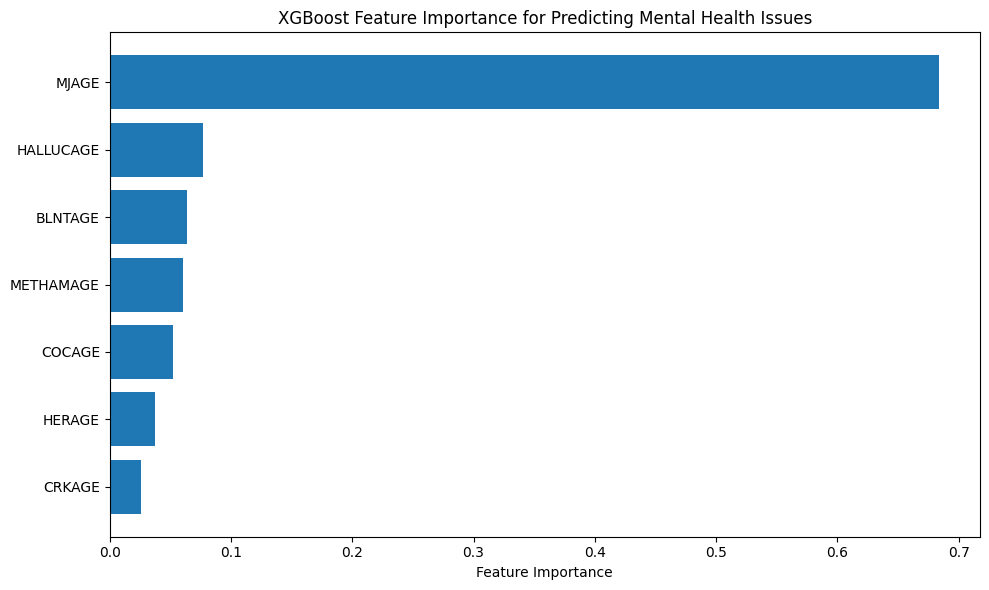

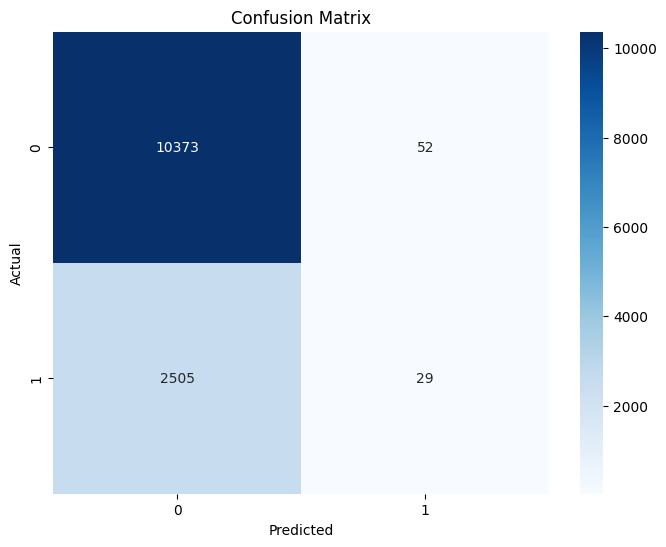


Model Parameters:
{'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 72, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None, 'use_label_encoder': False}


In [27]:
# Prepare the features and target
X = df_H1[drug_usage_columns_H1]
y = df_H1['YMDELT'].replace({2: 0}) # No Depression label is transformed as 0 for Model training

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Create and train the XGBoost model
xgb_model = XGBClassifier(random_state=72, use_label_encoder=False)
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot feature importance
plt.figure(figsize=(10, 6))
feature_importance = xgb_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(drug_usage_columns_H1)[sorted_idx])
plt.xlabel('Feature Importance')
plt.title('XGBoost Feature Importance for Predicting Mental Health Issues')
plt.tight_layout()
plt.show()

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Print model parameters
print("\nModel Parameters:")
print(xgb_model.get_params())


### Observations from Iteration 1

### **Overall Accuracy:**
- **Accuracy: 0.80**  
  This means that 80% of the predictions made by the model are correct. However, accuracy alone can be misleading, especially in cases of class imbalance, which seems to be present here (as indicated by the large difference in support between classes 0 and 1).

### **Class-wise Metrics:**
The report provides metrics for each class (0 and 1) across **precision**, **recall**, and **f1-score**.

#### **Class 0 (Majority Class):**
- **Precision: 0.81**  
  Out of all instances predicted as class 0, 81% were correct.
  
- **Recall: 1.00**  
  The model correctly identified all instances of class 0 (100% recall). This indicates that the model is highly sensitive to identifying class 0.
  
- **F1-score: 0.89**  
  The F1-score, which is the harmonic mean of precision and recall, is high at 0.89, reflecting strong overall performance for class 0.

#### **Class 1 (Minority Class):**
- **Precision: 0.36**  
  Only 36% of instances predicted as class 1 were actually class 1. This low precision suggests that the model makes many false-positive predictions for this class.
  
- **Recall: 0.01**  
  The model only identified about 1% of actual class 1 instances, indicating a severe issue with sensitivity for this class.
  
- **F1-score: 0.02**  
  The F1-score is extremely low, reflecting poor performance in balancing precision and recall for class 1.

### **Macro Averages:**
- **Precision: 0.58**, **Recall: 0.50**, **F1-score: 0.46**  
   These are unweighted averages across both classes. They show that, on average, the model's performance is moderate but skewed by the poor performance on class 1.

### **Weighted Averages:**
- **Precision: 0.72**, **Recall: 0.80**, **F1-score: 0.72**  
   These metrics take into account the number of instances (support) for each class, giving more weight to the majority class (class 0). The weighted averages are higher because class 0 dominates the dataset.

### **Key Observations:**
1. **Class Imbalance:** There is a significant imbalance between classes (10425 instances of class 0 vs. only 2534 instances of class 1). This imbalance is likely contributing to the poor performance on class 1.
2. **Poor Minority Class Performance:** The model struggles heavily with detecting instances of class 1, as shown by its very low recall (0.01) and F1-score (0.02). This suggests that the model is biased towards predicting the majority class (class 0).
3. **High Accuracy but Misleading:** While the accuracy is relatively high at 80%, it’s misleading due to the severe imbalance in prediction quality between classes.



### Iteration 2

In [28]:
df_H1['YMDELT'].value_counts()

YMDELT
2    52068
1    12727
Name: count, dtype: int64

In [30]:
df_H1_no = df_H1[df_H1['YMDELT']==2]
df_H1_yes = df_H1[df_H1['YMDELT']==1]

#Under sampling
df_H1_no = df_H1_no.sample(n=len(df_H1_yes), random_state=42)
df_H1_balanced = pd.concat([df_H1_no, df_H1_yes])

# Shuffling
df_H1_balanced = df_H1_balanced.sample(frac=1, random_state=42).reset_index(drop=True)



Accuracy: 0.58

Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.87      0.68      2559
           1       0.69      0.30      0.42      2532

    accuracy                           0.58      5091
   macro avg       0.62      0.58      0.55      5091
weighted avg       0.62      0.58      0.55      5091



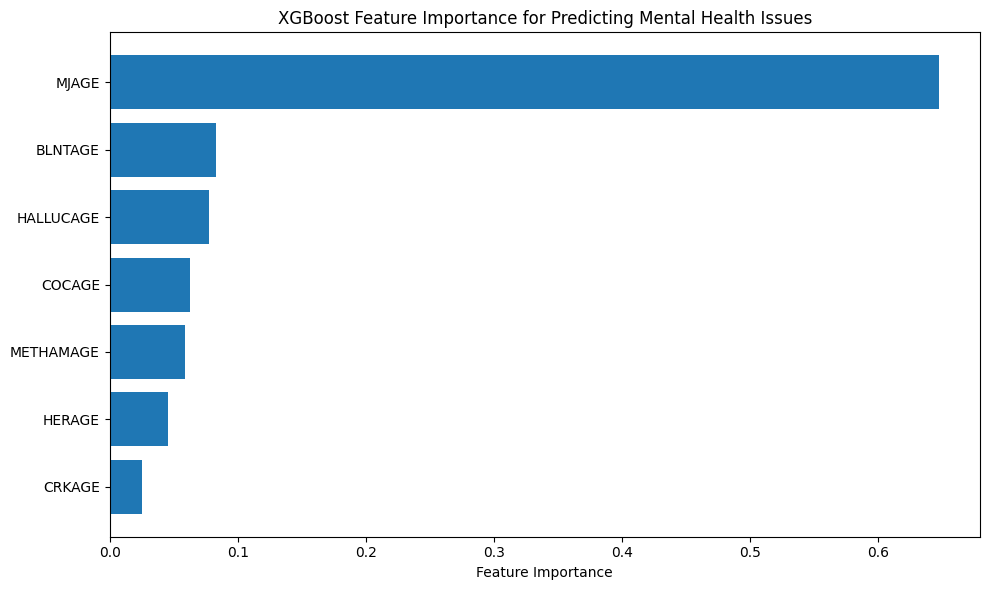

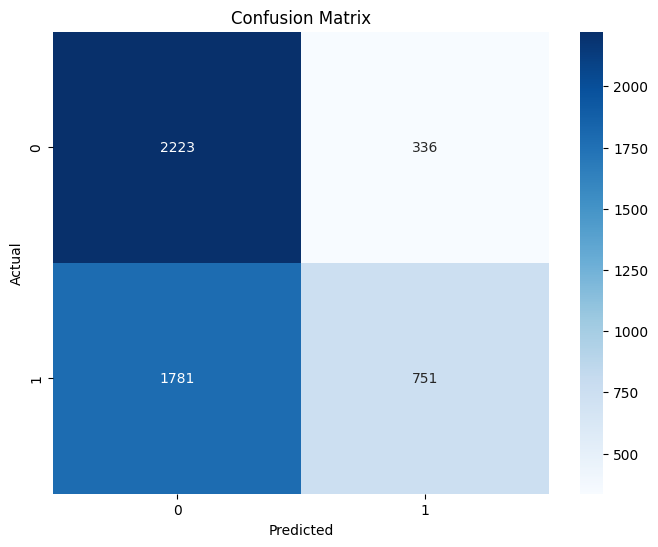


Model Parameters:
{'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 72, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None, 'use_label_encoder': False}


In [31]:
# Prepare the features and target
X = df_H1_balanced[drug_usage_columns_H1]
y = df_H1_balanced['YMDELT'].replace({2: 0}) # No Depression label is transformed as 0 for Model training

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Create and train the XGBoost model
xgb_model = XGBClassifier(random_state=72, use_label_encoder=False)
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot feature importance
plt.figure(figsize=(10, 6))
feature_importance = xgb_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(drug_usage_columns_H1)[sorted_idx])
plt.xlabel('Feature Importance')
plt.title('XGBoost Feature Importance for Predicting Mental Health Issues')
plt.tight_layout()
plt.show()

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Print model parameters
print("\nModel Parameters:")
print(xgb_model.get_params())


In [63]:
y

0        0
1        0
2        0
3        1
4        1
        ..
25449    1
25450    0
25451    0
25452    1
25453    1
Name: YMDELT, Length: 25454, dtype: int64

/Users/sharanraj/vscode/Data Intensive Computing/Project/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:28:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/sharanraj/vscode/Data Intensive Computing/Project/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:28:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/sharanraj/vscode/Data Intensive Computing/Project/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:28:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/sharanraj/vscode/Data Intensive Computing/Project/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:28:37] WAR

Best Parameters: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.8}
Accuracy: 0.5834
ROC AUC: 0.5835

Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.86      0.68      2559
           1       0.68      0.30      0.42      2532

    accuracy                           0.58      5091
   macro avg       0.62      0.58      0.55      5091
weighted avg       0.62      0.58      0.55      5091



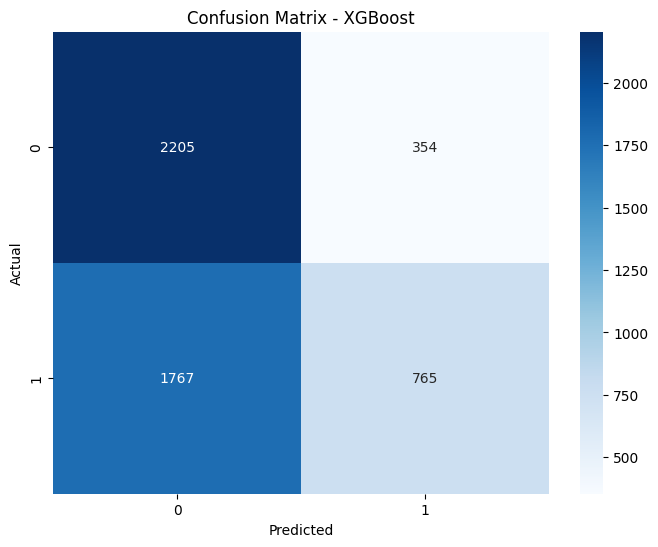

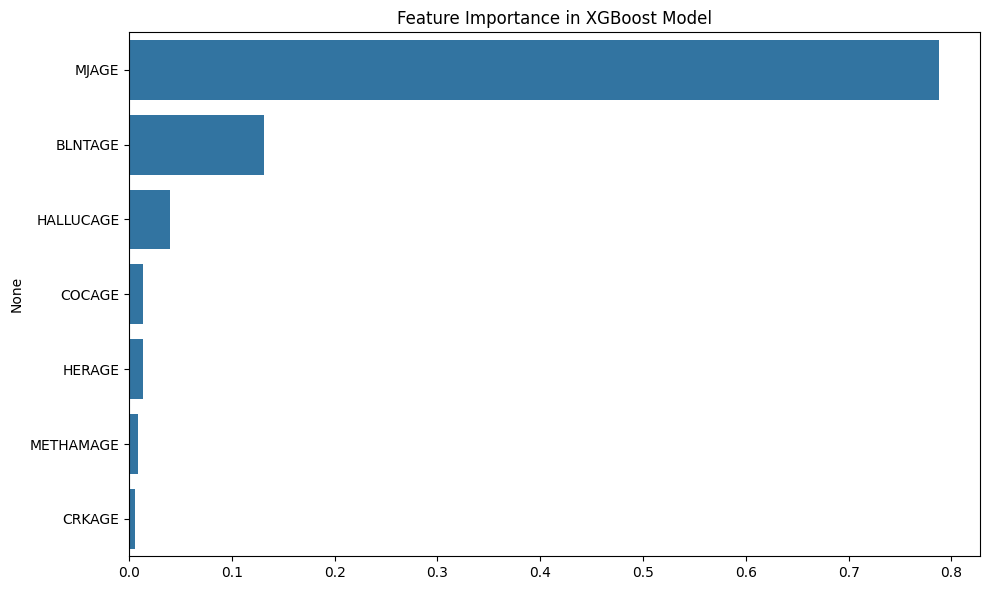

In [70]:
# Prepare the features and target
X = df_H1_balanced[drug_usage_columns_H1]
y = df_H1_balanced['YMDELT'].replace({2: 0}) # No Depression label is transformed as 0 for Model training

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Handle class imbalance
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# 3. Hyperparameter Tuning using RandomizedSearchCV for XGBoost
xgb_params = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [100, 200, 300],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Perform Randomized Search on hyperparameters using cross-validation
xgb_random_search = RandomizedSearchCV(xgb_model, param_distributions=xgb_params,
                                       n_iter=20, cv=5, scoring='accuracy',
                                       random_state=42, n_jobs=-1)
xgb_random_search.fit(X_train, y_train)

# Get the best model from Randomized Search
best_xgb_model = xgb_random_search.best_estimator_

# Make predictions on the test set
y_pred_xgb = best_xgb_model.predict(X_test)

# Evaluate the model performance
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
roc_auc_xgb = roc_auc_score(y_test, best_xgb_model.predict_proba(X_test)[:, 1])

print(f"Best Parameters: {xgb_random_search.best_params_}")
print(f"Accuracy: {accuracy_xgb:.4f}")
print(f"ROC AUC: {roc_auc_xgb:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))

# Confusion Matrix Visualization
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - XGBoost')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Feature Importance Plot for XGBoost Model
def plot_feature_importance(model):
    importance = model.feature_importances_
    sorted_idx = np.argsort(importance)[::-1]
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=importance[sorted_idx], y=X.columns[sorted_idx])
    plt.title("Feature Importance in XGBoost Model")
    plt.tight_layout()
    plt.show()

plot_feature_importance(best_xgb_model)



In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_H1 is your preprocessed DataFrame from the previous analysis

# Prepare the features and target
X = df_H1_balanced[drug_usage_columns_H1]
y = df_H1_balanced['YMDELT'].replace({2: 0}) # No Depression label is transformed as 0 for Model training

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the parameter grid for RandomizedSearchCV
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Initialize the Random Forest classifier
rf = RandomForestClassifier(random_state=42)

# Perform RandomizedSearchCV
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, 
                               n_iter=100, cv=5, random_state=42, n_jobs=-1)
rf_random.fit(X_train_scaled, y_train)

# Get the best model
best_rf = rf_random.best_estimator_

# Make predictions
y_pred = best_rf.predict(X_test_scaled)

# Print the results
print("Best parameters:", rf_random.best_params_)
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot feature importance
feature_importance = best_rf.feature_importances_
feature_names = X.columns

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance, y=feature_names)
plt.title("Feature Importance in Random Forest Model")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Partial dependence plot for 'Drug_Use'
from sklearn.inspection import PartialDependenceDisplay

features = ['Drug_Use']
PartialDependenceDisplay.from_estimator(best_rf, X_test_scaled, features, feature_names=X.columns)
plt.title("Partial Dependence Plot for Drug Use")
plt.show()

### Logistic Regression

Accuracy: 0.8044
ROC AUC: 0.5798

Classification Report:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89     10425
           1       0.33      0.00      0.00      2534

    accuracy                           0.80     12959
   macro avg       0.57      0.50      0.45     12959
weighted avg       0.71      0.80      0.72     12959



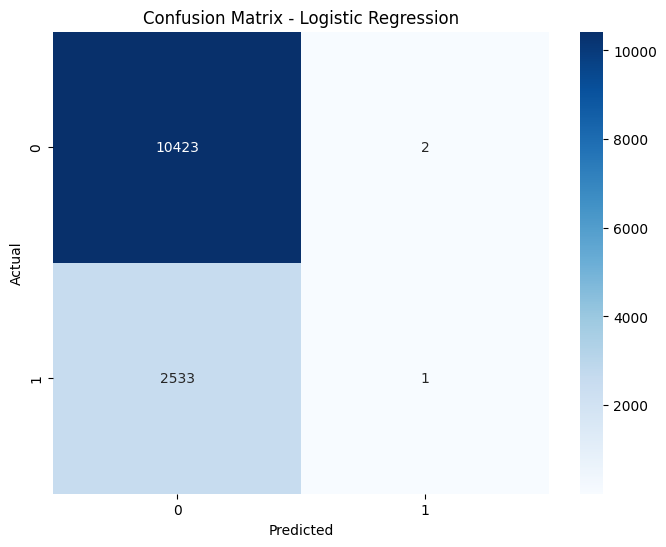

     Feature  Coefficient  Odds Ratio
8   Drug_Use         0.21        1.23
2    BLNTAGE         0.02        1.02
0   QUESTID2         0.01        1.01
7  METHAMAGE         0.01        1.01
4     CRKAGE         0.01        1.01
3     COCAGE        -0.01        0.99
5     HERAGE        -0.02        0.98
6  HALLUCAGE        -0.05        0.95
1      MJAGE        -0.16        0.85


In [67]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_H1 is your preprocessed DataFrame from Hypothesis 1
X = df_H1[drug_usage_columns_H1 + ['Drug_Use']]
y = df_H1['YMDELT'].replace({2: 0}) # No Depression label is transformed as 0 for Model training
# Step 1: Data Preprocessing
# Convert 'YMDELT' into binary format (1 = Mental Health Issue, 0 = No Mental Health Issue)
df_H1['YMDELT'] = df_H1['YMDELT'].apply(lambda x: 1 if x == 1 else 0)

# Prepare features and target variable
X = df_H1.drop('YMDELT', axis=1)  # Features (drug usage columns)
y = df_H1['YMDELT']               # Target (Mental Health Issues)

# Step 2: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Scale Features (optional but recommended)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 4: Train Logistic Regression Model
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train_scaled, y_train)

# Step 5: Make Predictions and Evaluate Model
y_pred = log_reg.predict(X_test_scaled)
y_pred_proba = log_reg.predict_proba(X_test_scaled)[:, 1]

# Accuracy and Classification Report
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Step 6: Interpret Coefficients
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': log_reg.coef_[0]
})
coefficients['Odds Ratio'] = np.exp(coefficients['Coefficient'])
print(coefficients.sort_values(by='Odds Ratio', ascending=False))

Accuracy: 0.5840
ROC AUC: 0.5836

Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.86      0.68      2559
           1       0.68      0.30      0.42      2532

    accuracy                           0.58      5091
   macro avg       0.62      0.58      0.55      5091
weighted avg       0.62      0.58      0.55      5091



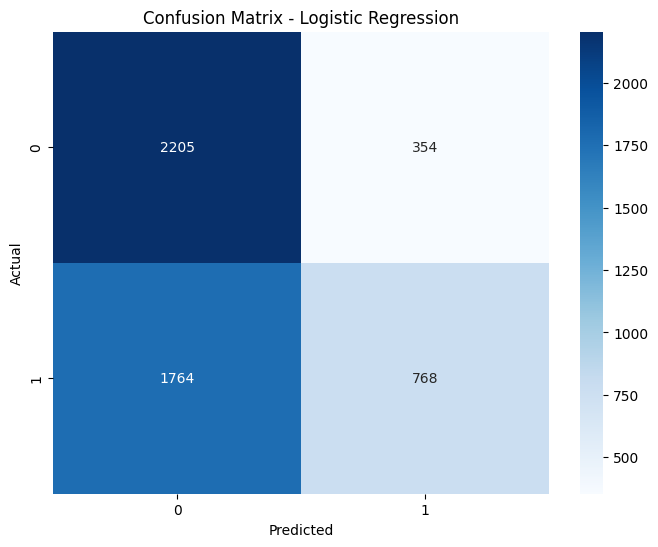

     Feature  Coefficient  Odds Ratio
7   Drug_Use         0.22        1.25
0      MJAGE         0.17        1.19
5  HALLUCAGE         0.05        1.05
4     HERAGE         0.04        1.04
2     COCAGE         0.01        1.01
3     CRKAGE         0.01        1.01
1    BLNTAGE        -0.01        0.99
6  METHAMAGE        -0.01        0.99


In [69]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_H1 is your preprocessed DataFrame from Hypothesis 1
X = df_H1_balanced[drug_usage_columns_H1 + ['Drug_Use']]
y = df_H1_balanced['YMDELT'].replace({2: 0}) # No Depression label is transformed as 0 for Model training



# Step 2: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Scale Features (optional but recommended)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 4: Train Logistic Regression Model
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train_scaled, y_train)

# Step 5: Make Predictions and Evaluate Model
y_pred = log_reg.predict(X_test_scaled)
y_pred_proba = log_reg.predict_proba(X_test_scaled)[:, 1]

# Accuracy and Classification Report
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Step 6: Interpret Coefficients
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': log_reg.coef_[0]
})
coefficients['Odds Ratio'] = np.exp(coefficients['Coefficient'])
print(coefficients.sort_values(by='Odds Ratio', ascending=False))

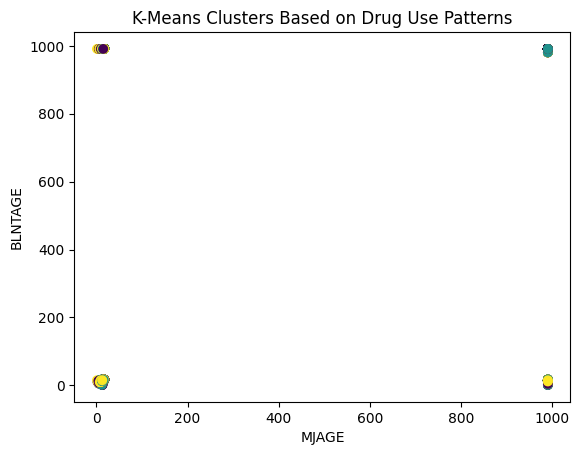

In [145]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Prepare features for clustering (e.g., drug usage columns)
X_clustering = df_H1.drop('YMDELT', axis=1)  # Exclude target variable

# Apply K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)  # Choose 3 clusters as an example
clusters = kmeans.fit_predict(X_clustering)

# Add cluster labels to the DataFrame
df_H1['Cluster'] = clusters

# Visualize clusters using a scatter plot (if you have 2D data)
plt.scatter(X_clustering['MJAGE'], X_clustering['BLNTAGE'], c=clusters, cmap='viridis')
plt.xlabel('MJAGE')
plt.ylabel('BLNTAGE')
plt.title('K-Means Clusters Based on Drug Use Patterns')
plt.show()

In [92]:
df_H1

,QUESTID2,MJAGE,BLNTAGE,COCAGE,CRKAGE,HERAGE,HALLUCAGE,METHAMAGE,YMDELT,Drug_Use,MJAGE_used,BLNTAGE_used,COCAGE_used,CRKAGE_used,HERAGE_used,HALLUCAGE_used,METHAMAGE_used
0,25095143,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,70925143,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0
7,63765143,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0
8,57796143,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0
11,40016143,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56009,25768630,16,0,0,0,0,0,0,2,1,1,0,0,0,0,0,0
56040,79723630,14,0,0,0,0,0,0,2,1,1,0,0,0,0,0,0
56041,31043630,13,15,0,0,0,0,0,1,1,1,1,0,0,0,0,0
56105,18392730,17,0,0,0,0,0,0,2,1,1,0,0,0,0,0,0


In [93]:
X_train_balanced

,MJAGE,BLNTAGE,COCAGE,CRKAGE,HERAGE,HALLUCAGE,METHAMAGE,Drug_Use
0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,10,0,1
3,13,16,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
83281,0,0,0,0,0,0,0,0
83282,13,14,0,0,0,0,0,1
83283,0,0,0,0,0,0,0,0
83284,0,0,0,0,0,0,0,0


<Axes: ylabel='Frequency'>

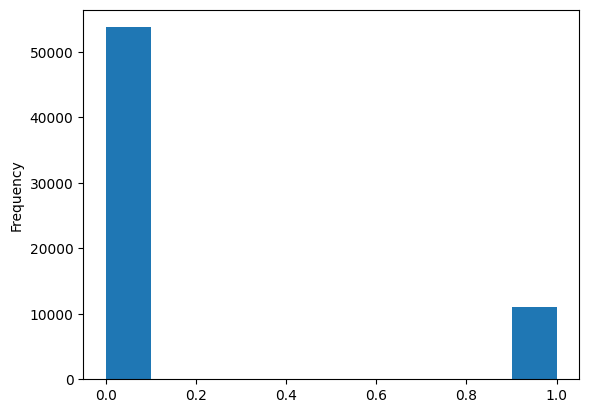

In [100]:
df_H1["Drug_Use"].plot(kind="hist")

In [117]:
for col in ["IRSEX","NEWRACE2", "IIFSTAMP", "IRFAMIN3","IRHHSIZ2"]:
    print(f"{col}:{df[col].unique()}")


IRSEX:[1 2]
NEWRACE2:[1 7 5 2 4 3 6]
IIFSTAMP:[1 3]
IRFAMIN3:[1 4 7 2 6 3 5]
IRHHSIZ2:[1 4 5 2 6 3]


### H2

Accuracy: 0.9378

Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     28293
           1       0.00      0.00      0.00      1875

    accuracy                           0.94     30168
   macro avg       0.47      0.50      0.48     30168
weighted avg       0.88      0.94      0.91     30168



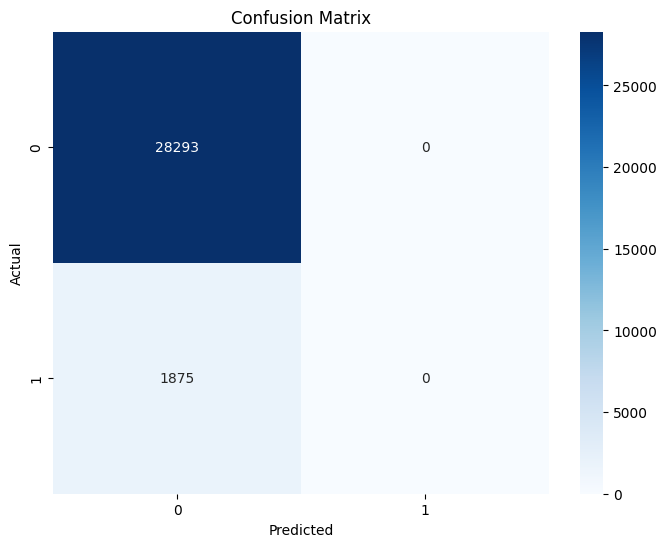

T-statistic: -50.29485285552048
P-value: 0.0


KeyError: 'IRMARIT_Married'

In [118]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Assuming df_H2 is your preprocessed DataFrame for Hypothesis 2

# Step 1: Data Preprocessing
# Replace missing values in IRMARIT (Marital Status) and SUICTHNK (Suicidal Thoughts)
df_H2['IRMARIT'].replace({1: 'Married', 2: 'Widowed', 4: 'Single', 99: np.nan}, inplace=True)
df_H2['SUICTHNK'].replace({1: 1, 2: 0, 99: np.nan}, inplace=True)  # Convert SUICTHNK into binary (1 = Suicidal Thoughts, 0 = No Suicidal Thoughts)

# Drop rows with missing values
df_H2.dropna(inplace=True)

# Step 2: Feature Engineering
# Create dummy variables for Marital Status (Married, Widowed, Single)
df_H2 = pd.get_dummies(df_H2, columns=['IRMARIT'], drop_first=True)

# Prepare features and target variable
X = df_H2.drop('SUICTHNK', axis=1)  # Features (Marital Status dummies)
y = df_H2['SUICTHNK']               # Target (Suicidal Thoughts)

# Step 3: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Train Logistic Regression Model
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)

# Make predictions on test set
y_pred = log_reg.predict(X_test)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Step 5: Statistical Test (T-test)
single_df = df_H2[df_H2['IRMARIT_Single'] == 1]
not_single_df = df_H2[df_H2['IRMARIT_Single'] == 0]

t_statistic, p_value = stats.ttest_ind(not_single_df['SUICTHNK'], single_df['SUICTHNK'])
print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}")

# Step 6: Visualization - Stacked Bar Chart of Suicidal Thoughts by Marital Status
marital_status_0 = df_H2[df_H2['IRMARIT_Single'] == 1]['SUICTHNK'].value_counts(normalize=True)
marital_status_1 = df_H2[df_H2['IRMARIT_Married'] == 1]['SUICTHNK'].value_counts(normalize=True)
marital_status_2 = df_H2[df_H2['IRMARIT_Widowed'] == 1]['SUICTHNK'].value_counts(normalize=True)

fig, ax = plt.subplots(figsize=(12,6))
labels = ['Single', 'Married', 'Widowed']
no_suicidal_thoughts = [marital_status_0.get(0,0), marital_status_1.get(0,0), marital_status_2.get(0,0)]
suicidal_thoughts = [marital_status_0.get(1,0), marital_status_1.get(1,0), marital_status_2.get(1,0)]

ax.bar(labels, no_suicidal_thoughts, label='No Suicidal Thoughts', color='lightblue')
ax.bar(labels, suicidal_thoughts, bottom=no_suicidal_thoughts, label='Suicidal Thoughts')

ax.set_ylabel('Proportion')
ax.set_title('Correlation between Marital Status and Suicidal Thoughts')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

for i in range(len(labels)):
    ax.text(i, no_suicidal_thoughts[i]/2,
            f'{no_suicidal_thoughts[i]:.1%}', ha='center', va='center')
    ax.text(i,
            no_suicidal_thoughts[i] + suicidal_thoughts[i]/2,
            f'{suicidal_thoughts[i]:.1%}', ha='center', va='center')

plt.tight_layout()
plt.show()